In [2]:
# Sets seeds for reproducability.

import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from dataset import YouCookII
from dataset import YouCookIICollate
from torch.utils.data import DataLoader
from loss import *
from accuracy import *
from transformers import get_linear_schedule_with_warmup
from model import Model
from torch import nn

import numpy as np
import torch
import matplotlib.pyplot as plt

def train(model, num_actions_train=[8], num_actions_valid=6, batch_size=4, epochs=25, lr=0.001, MAX_DETECTIONS=20):    
    train_datasets = [YouCookII(num_action, "/h/sagar/ece496-capstone/datasets/ycii") for num_action in num_actions_train]
    valid_dataset = YouCookII(num_actions_valid, "/h/sagar/ece496-capstone/datasets/ycii")
    
    train_size = sum([len(train_dataset) for train_dataset in train_datasets])
    valid_size = len(valid_dataset)
    
    print("Training Dataset Size: {}, Validation Dataset Size: {}".format(train_size, valid_size))
        
    collate = YouCookIICollate(MAX_DETECTIONS=MAX_DETECTIONS)
    
    train_dataloaders = [DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
                         for train_dataset in train_datasets]
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate, drop_last=True, worker_init_fn=seed_worker)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, int(0.2*epochs), epochs)

    train_loss = np.zeros(epochs)
    valid_loss = np.zeros(epochs)
    
    train_accuracy = np.zeros(epochs)
    valid_accuracy = np.zeros(epochs)
    
    for epoch in range(epochs):
        model.train()
        
        epoch_loss = 0.
        num_batches = 0
        
        total = 0
        correct = 0
        
        for train_dataloader in train_dataloaders:
            for data in train_dataloader:
                _, bboxes, features, steps, entities, entity_count, _, _ = data

                # Zero out any gradients.
                optimizer.zero_grad()

                # Run inference (forward pass).
                loss_data, VG, RR = model(steps, features, bboxes, entities, entity_count)

                # Loss from alignment.
                loss_ = compute_loss_batched(loss_data)

                # Backpropagation (backward pass).
                loss_.backward()

                # Update parameters.
                optimizer.step()

                epoch_loss += loss_
                num_batches += 1
            
        # Scheduler update.
        scheduler.step()
        epoch_loss = epoch_loss / (num_batches * batch_size)
        
        # Save loss and accuracy at each epoch and plot.
        train_loss[epoch] = float(epoch_loss)
        train_accuracy[epoch] = get_alignment_accuracy(model, train_dataloader, batch_size) 
        
        valid_loss[epoch] = get_alignment_loss(model, valid_dataloader, batch_size)
        valid_accuracy[epoch] = get_alignment_accuracy(model, valid_dataloader, batch_size)

        print("Epoch {} - Train Loss: {:.2f}, Validation Loss: {:.2f}, Train Accuracy: {:.2f}, Validation Accuracy: {:.2f}"
              .format(epoch + 1, train_loss[epoch], valid_loss[epoch], train_accuracy[epoch], valid_accuracy[epoch]))
    
    plt.figure()
    plt.plot(train_loss, label='train loss')
    plt.plot(valid_loss, label='valid loss')
    plt.legend()
    
    plt.figure()
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(valid_accuracy, label='valid accuracy')
    plt.legend()
    
    plt.show()
        
    return train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(device)

Training Dataset Size: 206, Validation Dataset Size: 66
Epoch 1 - Train Loss: 751.99, Validation Loss: 640.00, Train Accuracy: 0.51, Validation Accuracy: 0.49
Epoch 2 - Train Loss: 735.48, Validation Loss: 612.44, Train Accuracy: 0.51, Validation Accuracy: 0.48
Epoch 3 - Train Loss: 711.04, Validation Loss: 625.27, Train Accuracy: 0.48, Validation Accuracy: 0.49
Epoch 4 - Train Loss: 689.68, Validation Loss: 613.35, Train Accuracy: 0.52, Validation Accuracy: 0.50
Epoch 5 - Train Loss: 695.75, Validation Loss: 599.43, Train Accuracy: 0.55, Validation Accuracy: 0.51
Epoch 6 - Train Loss: 666.10, Validation Loss: 594.67, Train Accuracy: 0.50, Validation Accuracy: 0.50
Epoch 7 - Train Loss: 649.05, Validation Loss: 592.94, Train Accuracy: 0.58, Validation Accuracy: 0.52
Epoch 8 - Train Loss: 601.91, Validation Loss: 576.39, Train Accuracy: 0.51, Validation Accuracy: 0.53
Epoch 9 - Train Loss: 552.84, Validation Loss: 605.45, Train Accuracy: 0.57, Validation Accuracy: 0.56
Epoch 10 - Train 

Epoch 80 - Train Loss: 10.03, Validation Loss: 593.85, Train Accuracy: 0.93, Validation Accuracy: 0.60
Epoch 81 - Train Loss: 9.83, Validation Loss: 607.07, Train Accuracy: 0.94, Validation Accuracy: 0.59
Epoch 82 - Train Loss: 9.95, Validation Loss: 589.92, Train Accuracy: 0.95, Validation Accuracy: 0.59
Epoch 83 - Train Loss: 9.48, Validation Loss: 602.54, Train Accuracy: 0.95, Validation Accuracy: 0.59
Epoch 84 - Train Loss: 9.70, Validation Loss: 589.30, Train Accuracy: 0.93, Validation Accuracy: 0.60
Epoch 85 - Train Loss: 9.56, Validation Loss: 591.30, Train Accuracy: 0.94, Validation Accuracy: 0.60
Epoch 86 - Train Loss: 10.00, Validation Loss: 617.58, Train Accuracy: 0.94, Validation Accuracy: 0.59
Epoch 87 - Train Loss: 9.77, Validation Loss: 608.25, Train Accuracy: 0.94, Validation Accuracy: 0.60
Epoch 88 - Train Loss: 9.60, Validation Loss: 615.01, Train Accuracy: 0.94, Validation Accuracy: 0.60
Epoch 89 - Train Loss: 9.67, Validation Loss: 595.57, Train Accuracy: 0.94, Vali

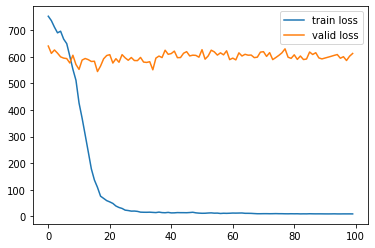

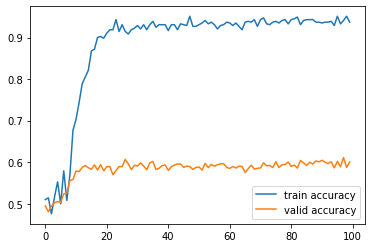

In [5]:
# Trainer.

num_actions_train = [8, 7, 5, 4]
num_actions_valid = 6
batch_size = 4
epochs = 100
lr = 1e-4

train_loss, valid_loss, train_accuracy, valid_accuracy, VG, loss_data, data = train(
    model, 
    num_actions_train=num_actions_train,  
    num_actions_valid=num_actions_valid, 
    batch_size=batch_size, 
    epochs=epochs, 
    lr=lr
)

In [6]:
# Evaluation.

from eval_fi import eval_all_dataset
eval_all_dataset(model, path="/h/sagar/ece496-capstone/datasets/fi")

--------------------------------------------------
Action 1: in a bowl, add ground beef, salt, pepper, 1 egg, dijon mustard and bread crumbs
Best IoU possible = 0.814872145652771
Random Candidate IoU = 0.582001805305481
Chosen Frame IoU: 0.37387269735336304
Best IoU possible = 0.5932643413543701
Random Candidate IoU = 0.43438395857810974
Chosen Frame IoU: 0.37369081377983093
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: mix the ingredients with hand
Best IoU possible = 0.6298992037773132
Random Candidate IoU = 0.35797545313835144
Chosen Frame IoU: 0.5334117412567139
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add vegetable oil in a pan
Best IoU possible = 0.7462273240089417
Random Candidat

Best IoU possible = 0.7823083400726318
Random Candidate IoU = 0.16010397672653198
Chosen Frame IoU: 0.5021249055862427
Best IoU possible = 0.621212363243103
Random Candidate IoU = 0.3642124533653259
Chosen Frame IoU: 0.41937926411628723
--------------------------------------------------
Action 9: sprinkle cheese onto the pizza
Best IoU possible = 0.7516839504241943
Random Candidate IoU = 0.35769495368003845
Chosen Frame IoU: 0.41993987560272217
Best IoU possible = 0.6143364310264587
Random Candidate IoU = 0.37304651737213135
Chosen Frame IoU: 0.42806077003479004
Mean Upper Bound IoU: 0.6953715085983276, Mean Random IoU: 0.3347298502922058, Mean Model IoU: 0.3682190179824829
Top-1 acc@0.5:
Proposal Upper Bound: 0.9375, Random: 0.25, Model: 0.125
--------------------------------------------------
Action 1: cut the cabbage into small pieces
Best IoU possible = 0.9013723731040955
Random Candidate IoU = 0.15885815759608485
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
-

--------------------------------------------------
Action 1: Soak the ribs in water
Best IoU possible = 0.5058745682595212
Random Candidate IoU = 0.14596101641654968
Chosen Frame IoU: 0.2540847361087799
Best IoU possible = 0.8695003390312195
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: peel the apple and kiwi
Best IoU possible = 0.8488753706881534
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.02603035420179367
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: cut the apple and kiwi
Best IoU possible = 0.20565617084503174
Random Candidate IoU = 0.09602852910757065
Chosen Frame IoU: 0.08481172893725054
This entity has no ground truth bounding box
--------------------------------------------------
Action 4: cut the onion and garlic
Best IoU possible = 0.09147238593275771
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.060276590287685394
Best IoU possible = 0.59521579742

--------------------------------------------------
Action 1: Add an egg yolk in mayo
Best IoU possible = 0.1718814903008678
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.6781991720199585
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.6190804839134216
--------------------------------------------------
Action 2: Shred some cheese in it
Best IoU possible = 0.05049420893192291
Random Candidate IoU = 0.015590877272188663
Chosen Frame IoU: 0.028766650706529617
Best IoU possible = 0.6483603715896606
Random Candidate IoU = 0.057043980807065964
Chosen Frame IoU: 0.1343051791191101
--------------------------------------------------
Action 3: add salt and pepper to it
Best IoU possible = 0.605575419552428
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.2439376413822174
Best IoU possible = 0.6424552202224731
Random Candidate IoU = 0.014786533080041409
Chosen Frame IoU: 0.23856058716773987
This entity has no ground truth bounding box
-----------------------------------------

Best IoU possible = 0.734688937664032
Random Candidate IoU = 0.32361242175102234
Chosen Frame IoU: 0.5877509117126465
Mean Upper Bound IoU: 0.6595121622085571, Mean Random IoU: 0.29372480511665344, Mean Model IoU: 0.41576480865478516
Top-1 acc@0.5:
Proposal Upper Bound: 0.95, Random: 0.2, Model: 0.3
--------------------------------------------------
Action 1: Cook pancetta in a pan with oil
Best IoU possible = 0.4850852815498209
Random Candidate IoU = 0.16156370547844587
Chosen Frame IoU: 0.0817803218960762
Best IoU possible = 0.6841245889663696
Random Candidate IoU = 0.09449581056833267
Chosen Frame IoU: 0.24357199668884277
--------------------------------------------------
Action 2: Melt butter in a pan
Best IoU possible = 0.1002126033087652
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.026453735306859016
Best IoU possible = 0.6172184944152832
Random Candidate IoU = 0.10962848365306854
Chosen Frame IoU: 0.4368600845336914
--------------------------------------------------
Action 3: 

Best IoU possible = 0.45863819122314453
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 8: Add the sauce and udon noodles to the pan
Best IoU possible = 0.7516318559646606
Random Candidate IoU = 0.3908262252807617
Chosen Frame IoU: 0.6838306784629822
Best IoU possible = 0.4628542959690094
Random Candidate IoU = 0.16801422834396362
Chosen Frame IoU: 0.39784306287765503
This entity has no ground truth bounding box
--------------------------------------------------
Action 9: stir
No entities detected for this action.
--------------------------------------------------
Action 10: place watercress on the dish
Best IoU possible = 0.12643451988697052
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 11: place the stir-fry on top of the watercress
Best IoU possible = 0.2951000928878784
Random Candidate IoU = 0.08555952995305705
Chosen F

--------------------------------------------------
Action 1: Add the meat to a bowl
Best IoU possible = 0.6369763016700745
Random Candidate IoU = 0.6007891443465666
Chosen Frame IoU: 0.35361555218696594
Best IoU possible = 0.7875245213508606
Random Candidate IoU = 0.7101652026176453
Chosen Frame IoU: 0.6426591277122498
--------------------------------------------------
Action 2: Add garlic salt, sugar, sesame oil, and sauce to the meat
Best IoU possible = 0.6602187752723694
Random Candidate IoU = 0.15193544328212738
Chosen Frame IoU: 0.08426237106323242
Best IoU possible = 0.6844748258590698
Random Candidate IoU = 0.14724017679691315
Chosen Frame IoU: 0.2560182213783264
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 3: Add cabbage, green onion, and carrots to the bowl
Best IoU possible = 0.9114023945345754
Random Candidate IoU = 0.19070383906

Best IoU possible = 0.7070802450180054
Random Candidate IoU = 0.38970884680747986
Chosen Frame IoU: 0.5288491249084473
--------------------------------------------------
Action 8: add the onion rings into it
Best IoU possible = 0.6545364856719971
Random Candidate IoU = 0.12070311605930328
Chosen Frame IoU: 0.13865423202514648
Best IoU possible = 0.7849301695823669
Random Candidate IoU = 0.19979828596115112
Chosen Frame IoU: 0.4706958532333374
--------------------------------------------------
Action 9: shake it well to coat
Best IoU possible = 0.6910412907600403
Random Candidate IoU = 0.05298576503992081
Chosen Frame IoU: 0.39873677492141724
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: Dip the onion rings into the batter
Best IoU possible = 0.8096163967366363
Random Candidate IoU = 0.32867470383644104
Chosen Frame IoU: 0.17670980095863342
Best IoU possible = 0.8245587944984436
Random Candidate IoU = 0.4146212339401245
Chosen

Best IoU possible = 0.7536062598228455
Random Candidate IoU = 0.057654861360788345
Chosen Frame IoU: 0.6488370895385742
--------------------------------------------------
Action 12: Cook some pasta in the pan
Best IoU possible = 0.2676323104726232
Random Candidate IoU = 0.11628503001844344
Chosen Frame IoU: 0.2385784517092004
Best IoU possible = 0.9638806581497192
Random Candidate IoU = 0.38617566227912903
Chosen Frame IoU: 0.6989827156066895
--------------------------------------------------
Action 13: mix it with the sauce and pecorino cheese
Best IoU possible = 0.6135243773460388
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.27098897099494934
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.19646905511337437
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.6040035486221313, Mean Random IoU: 0.15288563072681427, Mean Model IoU: 0.3323814272880554
Top-1 acc@0.5:
Proposal Upper Bound: 0.7083333333333334, Random: 0.08333333333333333, Model: 0.3

--------------------------------------------------
Action 1: cut through the core of the cabbage into half
Best IoU possible = 0.5999624133110046
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.5276438593864441
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: remove the tough core
Best IoU possible = 0.2688540816307068
Random Candidate IoU = 0.10127015604697501
Chosen Frame IoU: 0.06111018359661102
--------------------------------------------------
Action 3: dice the cabbage
Best IoU possible = 0.8618393233165826
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.04216652363538742
--------------------------------------------------
Action 4: Put the cabbage into a pan
Best IoU possible = 0.1904536932706833
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.046207904084511225
Best IoU possible = 0.7283530235290527
Random Candidate IoU = 0.4979017674922943
Chosen Frame IoU: 0.39066386222839355
------------------------------------------------

Best IoU possible = 0.7922376990318298
Random Candidate IoU = 0.5921725034713745
Chosen Frame IoU: 0.21188297867774963
--------------------------------------------------
Action 7: mix it up
Best IoU possible = 0.8677593469619751
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.7424811720848083
--------------------------------------------------
Action 8: Fry the marinated chicken in a frying pan
Best IoU possible = 0.5481219291687012
Random Candidate IoU = 0.3442018926143646
Chosen Frame IoU: 0.2273252159357071
Best IoU possible = 0.6326996684074402
Random Candidate IoU = 0.3978898227214813
Chosen Frame IoU: 0.4218211770057678
--------------------------------------------------
Action 9: mix sesame oil, red chili in a pan
Best IoU possible = 0.1915578544139862
Random Candidate IoU = 0.02020462043583393
Chosen Frame IoU: 0.05692281588750211
Best IoU possible = 0.6757965087890625
Random Candidate IoU = 0.4394192099571228
Chosen Frame IoU: 0.40589243173599243
This entity has no ground truth b

Best IoU possible = 0.6723319292068481
Random Candidate IoU = 0.586617648601532
Chosen Frame IoU: 0.5919000506401062
Best IoU possible = 0.5171838402748108
Random Candidate IoU = 0.3791545331478119
Chosen Frame IoU: 0.3200278878211975
--------------------------------------------------
Action 10: Add distilled vinegar to a pan of hot water
Best IoU possible = 0.8786023855209351
Random Candidate IoU = 0.2270300964805585
Chosen Frame IoU: 0.15301889498906399
Best IoU possible = 0.5465701222419739
Random Candidate IoU = 0.24915938079357147
Chosen Frame IoU: 0.34404894709587097
--------------------------------------------------
Action 11: add eggs
Best IoU possible = 0.44652411341667175
Random Candidate IoU = 0.008350911550223827
Chosen Frame IoU: 0.2557521164417267
--------------------------------------------------
Action 12: split english muffins onto a tray
Best IoU possible = 0.7472587486994063
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.46345725655555725
Best IoU possible = 0.650983

Best IoU possible = 0.7337489724159241
Random Candidate IoU = 0.5714751482009888
Chosen Frame IoU: 0.7024515867233276
--------------------------------------------------
Action 8: stir
No entities detected for this action.
--------------------------------------------------
Action 9: mix flour and water together
Best IoU possible = 0.4981424414739846
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: heat the paste in the microwave
Best IoU possible = 0.5879206758992289
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8753164410591125
Random Candidate IoU = 0.4865075647830963
Chosen Frame IoU: 0.34551572799682617
--------------------------------------------------
Action 11: place the filling on the corner of the wrapper
Best IoU possible = 0.5423713070039184
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
Best IoU possible = 0.8295284509658813
Random Candidate I

Best IoU possible = 0.7382032871246338
Random Candidate IoU = 0.027077268809080124
Chosen Frame IoU: 0.411766916513443
Best IoU possible = 0.5887230260069435
Random Candidate IoU = 0.297178715467453
Chosen Frame IoU: 0.2998678386211395
--------------------------------------------------
Action 10: Spread a layer of pizza sauce
Best IoU possible = 0.49806561342578604
Random Candidate IoU = 0.2504923641681671
Chosen Frame IoU: 0.2910028100013733
--------------------------------------------------
Action 11: add a layer of grated cheese
Best IoU possible = 0.6694362528398811
Random Candidate IoU = 0.4586627781391144
Chosen Frame IoU: 0.453559935092926
--------------------------------------------------
Action 12: place the sliced pepperoni
Best IoU possible = 0.504597657449338
Random Candidate IoU = 0.3878227045915503
Chosen Frame IoU: 0.3553386330604553
--------------------------------------------------
Action 13: put the fried bacon on top
Best IoU possible = 0.7825869917869568
Random Cand

Best IoU possible = 0.785611093044281
Random Candidate IoU = 0.00754528446123004
Chosen Frame IoU: 0.3785829544067383
Best IoU possible = 0.6322412490844727
Random Candidate IoU = 0.5181914567947388
Chosen Frame IoU: 0.29985514283180237
--------------------------------------------------
Action 8: cook the prosciutto in it
Best IoU possible = 0.8371543288230896
Random Candidate IoU = 0.34756913781166077
Chosen Frame IoU: 0.6573416590690613
Best IoU possible = 0.6303503513336182
Random Candidate IoU = 0.37160247564315796
Chosen Frame IoU: 0.35991230607032776
--------------------------------------------------
Action 9: Turn off the heat when the prosciutto is crispy
This entity has no ground truth bounding box
--------------------------------------------------
Action 10: add the pasta to the boiling water
Best IoU possible = 0.35412248969078064
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.14281369745731354
Best IoU possible = 0.6924198865890503
Random Candidate IoU = 0.0
Chosen Frame Io

Best IoU possible = 0.17663724720478058
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.03165908526207775
Best IoU possible = 0.6219090223312378
Random Candidate IoU = 0.20373410375983123
Chosen Frame IoU: 0.25211353938679765
This entity has no ground truth bounding box
This entity has no ground truth bounding box
--------------------------------------------------
Action 8: mix
No entities detected for this action.
--------------------------------------------------
Action 9: Add oil to a hot pan
Best IoU possible = 0.4818908257469039
Random Candidate IoU = 0.1284732073545456
Chosen Frame IoU: 0.2524062395095825
Best IoU possible = 0.5076427459716797
Random Candidate IoU = 0.2199389934539795
Chosen Frame IoU: 0.34745851159095764
--------------------------------------------------
Action 10: add the vegetables 
Best IoU possible = 0.9262991547584534
Random Candidate IoU = 0.04385402053594589
Chosen Frame IoU: 0.7720232605934143
--------------------------------------------------
Action 11: 

--------------------------------------------------
Action 1: Mince onions
Best IoU possible = 0.7409681677818298
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.4022865295410156
--------------------------------------------------
Action 2: add ground beef to a bowl with them
Best IoU possible = 0.8272421360015869
Random Candidate IoU = 0.19619926810264587
Chosen Frame IoU: 0.49291929602622986
Best IoU possible = 0.5078838467597961
Random Candidate IoU = 0.3279978930950165
Chosen Frame IoU: 0.33480018377304077
--------------------------------------------------
Action 3: Add bread crumbs, parmesan cheese, soy sauce, crushed garlic, milk, egg
Best IoU possible = 0.8070440292358398
Random Candidate IoU = 0.019354164600372314
Chosen Frame IoU: 0.6735263466835022
Best IoU possible = 0.6905443668365479
Random Candidate IoU = 0.5795220732688904
Chosen Frame IoU: 0.22355438768863678
This entity has no ground truth bounding box
This entity has no ground truth bounding box
This entity has no ground

Best IoU possible = 0.837128758430481
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.381114661693573
--------------------------------------------------
Action 16: mix everything well in the bowl
Best IoU possible = 0.6276782155036926
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.3517414927482605
Best IoU possible = 0.717979907989502
Random Candidate IoU = 0.154319167137146
Chosen Frame IoU: 0.4698316156864166
--------------------------------------------------
Action 17: heat some butter in the pan
Best IoU possible = 0.9041432738304138
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.39215514063835144
Best IoU possible = 0.5462871789932251
Random Candidate IoU = 0.07653570175170898
Chosen Frame IoU: 0.4857479929924011
--------------------------------------------------
Action 18: pour in some mixture in to cook
Best IoU possible = 0.7968856692314148
Random Candidate IoU = 0.16983510553836823
Chosen Frame IoU: 0.1906391680240631
--------------------------------------------------
Action 19

Best IoU possible = 0.4955776333808899
Random Candidate IoU = 0.12225363403558731
Chosen Frame IoU: 0.05511699616909027
--------------------------------------------------
Action 12: chop it using a meat shopper
Best IoU possible = 0.5610923767089844
Random Candidate IoU = 0.16632884740829468
Chosen Frame IoU: 0.3641031086444855
This entity has no ground truth bounding box
--------------------------------------------------
Action 13: Add half a stick of butter
Best IoU possible = 0.4192182123661041
Random Candidate IoU = 0.14707587659358978
Chosen Frame IoU: 0.25108078122138977
--------------------------------------------------
Action 14: and mix it well
Best IoU possible = 0.6958732604980469
Random Candidate IoU = 0.3742290437221527
Chosen Frame IoU: 0.5026580095291138
--------------------------------------------------
Action 15: add black pepper and salt
Best IoU possible = 0.42647045850753784
Random Candidate IoU = 0.408104807138443
Chosen Frame IoU: 0.42647045850753784
Best IoU poss

Random Candidate IoU = 0.09675382077693939
Chosen Frame IoU: 0.5353491306304932
Mean Upper Bound IoU: 0.5694653391838074, Mean Random IoU: 0.15330100059509277, Mean Model IoU: 0.28409773111343384
Top-1 acc@0.5:
Proposal Upper Bound: 0.625, Random: 0.0625, Model: 0.21875
--------------------------------------------------
Action 1: Cut and shape the apple slices as to thick, flat and even surface
Best IoU possible = 0.0869375690817833
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.031129442577219744
--------------------------------------------------
Action 2: place the apple pieces on a plate
Best IoU possible = 0.11704448610544205
Random Candidate IoU = 0.06860826164484024
Chosen Frame IoU: 0.07302062819781278
Best IoU possible = 0.6942544271839328
Random Candidate IoU = 0.6942544271839328
Chosen Frame IoU: 0.4342024624347687
--------------------------------------------------
Action 3: season with salt and pepper
Best IoU possible = 0.7311486601829529
Random Candidate IoU = 0.3651657402

Best IoU possible = 0.33499500155448914
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 7: Pour the egg mixture in the pan to cook by stirring
Best IoU possible = 0.813934326171875
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.5627632141113281
Best IoU possible = 0.2752745449542999
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.0018228800036013126
Mean Upper Bound IoU: 0.5897131562232971, Mean Random IoU: 0.16546139121055603, Mean Model IoU: 0.28934401273727417
Top-1 acc@0.5:
Proposal Upper Bound: 0.6923076923076923, Random: 0.15384615384615385, Model: 0.23076923076923078
--------------------------------------------------
Action 1: Chop mushums into slices
Best IoU possible = 0.8662617206573486
Random Candidate IoU = 0.8662617206573486
Chosen Frame IoU: 0.23890183866024017
This entity has no ground truth bounding box
--------------------------------------------------
Action 2: cut onions, bell peppers into chunks
Best IoU poss

Best IoU possible = 0.699984073638916
Random Candidate IoU = 0.35202654485301793
Chosen Frame IoU: 0.37697169184684753
Best IoU possible = 0.6261117458343506
Random Candidate IoU = 0.4181315004825592
Chosen Frame IoU: 0.41967591643333435
This entity has no ground truth bounding box
--------------------------------------------------
Action 4: Add the chopped vegetables to the wok
Best IoU possible = 0.8204782009124756
Random Candidate IoU = 0.502379834651947
Chosen Frame IoU: 0.5649405717849731
Best IoU possible = 0.5139920115470886
Random Candidate IoU = 0.2945246994495392
Chosen Frame IoU: 0.40641501545906067
--------------------------------------------------
Action 5: stir
No entities detected for this action.
--------------------------------------------------
Action 6: Add the pork, green onion, and rice to the wok
Best IoU possible = 0.2653477403026177
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.2291429282314713
Best IoU possible = 0.4883774518966675
Random Candidate IoU = 0.371

Best IoU possible = 0.8719426989555359
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.35193681716918945
Best IoU possible = 0.757742702960968
Random Candidate IoU = 0.2818140685558319
Chosen Frame IoU: 0.6881335973739624
This entity has no ground truth bounding box
Mean Upper Bound IoU: 0.6316243410110474, Mean Random IoU: 0.2781870663166046, Mean Model IoU: 0.42095139622688293
Top-1 acc@0.5:
Proposal Upper Bound: 0.9230769230769231, Random: 0.07692307692307693, Model: 0.38461538461538464
--------------------------------------------------
Action 1: Remove the shell from the shrimp
This entity has no ground truth bounding box
Best IoU possible = 0.0329433486463102
Random Candidate IoU = 0.02392840057777427
Chosen Frame IoU: 0.0
--------------------------------------------------
Action 2: Make many small cuts into the shrimp
This entity has no ground truth bounding box
Best IoU possible = 0.011388705112040043
Random Candidate IoU = 0.0
Chosen Frame IoU: 0.004579348488441265
-------------

In [ ]:
# Visualizer.

from visualizer import inference

YCII = "/h/sagar/ece496-capstone/datasets/ycii"
FI = "/h/sagar/ece496-capstone/datasets/fi"

VG, RR = inference(model, 27, 0, FI)

In [ ]:
# Saving and loading weights.

SAVE = False
LOAD = True

if SAVE:
    torch.save(model.state_dict(), "/h/sagar/ece496-capstone/weights/t1")
    
if LOAD:
    model.load_state_dict(torch.load("/h/sagar/ece496-capstone/weights/t1"))

In [ ]:
# Reload modules.

import importlib
import visualizer
import eval_fi
import model as mdl
import loss

importlib.reload(visualizer)
importlib.reload(eval_fi)
importlib.reload(mdl)
importlib.reload(loss)